In [98]:
library(sqldf)
library(ggplot2)

In [70]:
airq25<-read.csv("PM2-5_2018_Daily.csv")
airq10<-read.csv("PM10_2018_Daily.csv")

In [71]:
colnames(airq25)<-c("id","da","pm25")
colnames(airq10)<-c("id","da","pm10")

In [72]:
airq<-sqldf("select a.id,a.da,a.pm25,b.pm10 from airq25 a, airq10 b where a.id=b.id and a.da=b.da")

In [73]:
airq

id,da,pm25,pm10
CU-S0001,28-02-2018,52.52500,102.73000
CU-S0002,15-02-2018,62.89826,123.37442
CU-S0002,16-02-2018,50.96376,96.69993
CU-S0002,17-02-2018,77.15833,143.26000
CU-S0002,18-02-2018,79.91827,141.49231
CU-S0002,19-02-2018,72.95452,133.82766
CU-S0002,20-02-2018,77.67401,141.67517
CU-S0002,21-02-2018,64.04096,114.19663
CU-S0002,22-02-2018,29.05366,50.32362
CU-S0002,23-02-2018,24.65841,41.67944


In [74]:
sensorlist<-read.csv("sensorlist.csv",encoding="UTF-8", stringsAsFactors=FALSE)
sensorlist[]     <- lapply(sensorlist, as.character)
Encoding(sensorlist$tambol)

[1] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[10] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[19] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[28] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[37] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[46] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[55] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[64] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[73] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[82] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"
[91] "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8" "UTF-8"

In [75]:
airq$date<-as.Date(airq$da,"%d-%m-%Y")

In [76]:
library(stringr)
airq$d<-str_split_fixed(airq$da, "-", 3)[,1]
airq$m<-str_split_fixed(airq$da, "-", 3)[,2]
airq$y<-str_split_fixed(airq$da, "-", 3)[,3]

In [77]:
airq$m<-as.numeric(airq$m)
airq$d<-as.numeric(airq$d)
airq$y<-as.numeric(airq$y)

In [123]:
airq$doy <- strftime(airq$date, format = "%j")
airq$doy<-as.numeric(airq$doy)

In [94]:
airq<-na.omit(airq)

In [78]:
airq$monthf<-factor(airq$m,levels=as.character(1:12),labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),ordered=TRUE)

In [79]:
airq$woy<-as.numeric(format(airq$date,"%W"))

In [80]:
library(plyr)
airq<-ddply(airq,.(m),transform,monthweek=1+woy-min(woy))

In [81]:
airq$dow<-as.POSIXlt(airq$date)$wday

In [130]:
airq

,id,da,pm25,pm10,date,d,m,y,monthf,woy,monthweek,dow,dowf,pm25f,doy
1,CU-S0001,28-02-2018,52.52500,102.73000,2018-02-28,28,2,2018,Feb,9,3,3,Wed,"(50,120]",59
2,CU-S0002,15-02-2018,62.89826,123.37442,2018-02-15,15,2,2018,Feb,7,1,4,Thu,"(50,120]",46
3,CU-S0002,16-02-2018,50.96376,96.69993,2018-02-16,16,2,2018,Feb,7,1,5,Fri,"(50,120]",47
4,CU-S0002,17-02-2018,77.15833,143.26000,2018-02-17,17,2,2018,Feb,7,1,6,Sat,"(50,120]",48
5,CU-S0002,18-02-2018,79.91827,141.49231,2018-02-18,18,2,2018,Feb,7,1,0,Sun,"(50,120]",49
6,CU-S0002,19-02-2018,72.95452,133.82766,2018-02-19,19,2,2018,Feb,8,2,1,Mon,"(50,120]",50
7,CU-S0002,20-02-2018,77.67401,141.67517,2018-02-20,20,2,2018,Feb,8,2,2,Tue,"(50,120]",51
8,CU-S0002,21-02-2018,64.04096,114.19663,2018-02-21,21,2,2018,Feb,8,2,3,Wed,"(50,120]",52
9,CU-S0002,22-02-2018,29.05366,50.32362,2018-02-22,22,2,2018,Feb,8,2,4,Thu,"(0,50]",53
10,CU-S0002,23-02-2018,24.65841,41.67944,2018-02-23,23,2,2018,Feb,8,2,5,Fri,"(0,50]",54


In [83]:
airq$dowf<-factor(airq$dow,levels=rev(0:6),labels=rev(c("Sun","Mon","Tue","Wed","Thu","Fri","Sat")),ordered=TRUE)

In [141]:
airqdaily<-sqldf('select date,y,monthf,monthweek,dowf,avg(pm25) from airq group by y,doy')
colnames(airqdaily)[6]<-"avgpm25"
maxpm25<-max(airqdaily$avgpm25)
airqdaily$pm25f<-cut(airqdaily$avgpm25,c(0,50,120,200,300,maxpm25))

In [142]:
airqdaily

date,y,monthf,monthweek,dowf,avgpm25,pm25f
2018-02-15,2018,Feb,1,Thu,59.39145,"(50,116]"
2018-02-16,2018,Feb,1,Fri,45.52833,"(0,50]"
2018-02-17,2018,Feb,1,Sat,48.32125,"(0,50]"
2018-02-18,2018,Feb,1,Sun,70.86032,"(50,116]"
2018-02-19,2018,Feb,2,Mon,69.84562,"(50,116]"
2018-02-20,2018,Feb,2,Tue,71.50545,"(50,116]"
2018-02-21,2018,Feb,2,Wed,62.86654,"(50,116]"
2018-02-22,2018,Feb,2,Thu,44.51564,"(0,50]"
2018-02-23,2018,Feb,2,Fri,24.17213,"(0,50]"
2018-02-24,2018,Feb,2,Sat,27.38526,"(0,50]"


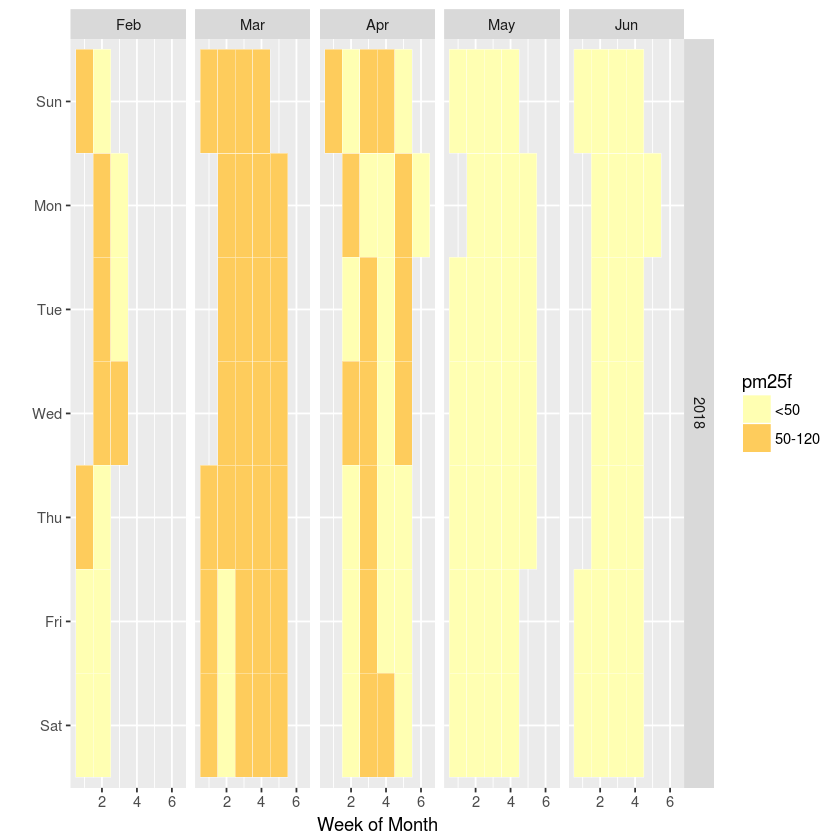

In [144]:
ggplot(airqdaily, aes(monthweek,dowf)) + geom_tile(aes(fill = pm25f),colour = "white") + scale_fill_manual(values=c("#ffffb2","#fecc5c","#fd8d3c"),labels = c("<50","50-120","120-200"))+ facet_grid(y~monthf) + xlab("Week of Month") + ylab("")

In [145]:
airqdaily<-sqldf('select date,y,monthf,monthweek,dowf,avg(pm10) from airq group by y,doy')
colnames(airqdaily)[6]<-"avgpm10"
maxpm10<-max(airqdaily$avgpm10)
airqdaily$pm10<-cut(airqdaily$avgpm10,c(0,50,100,200,300,maxpm10))

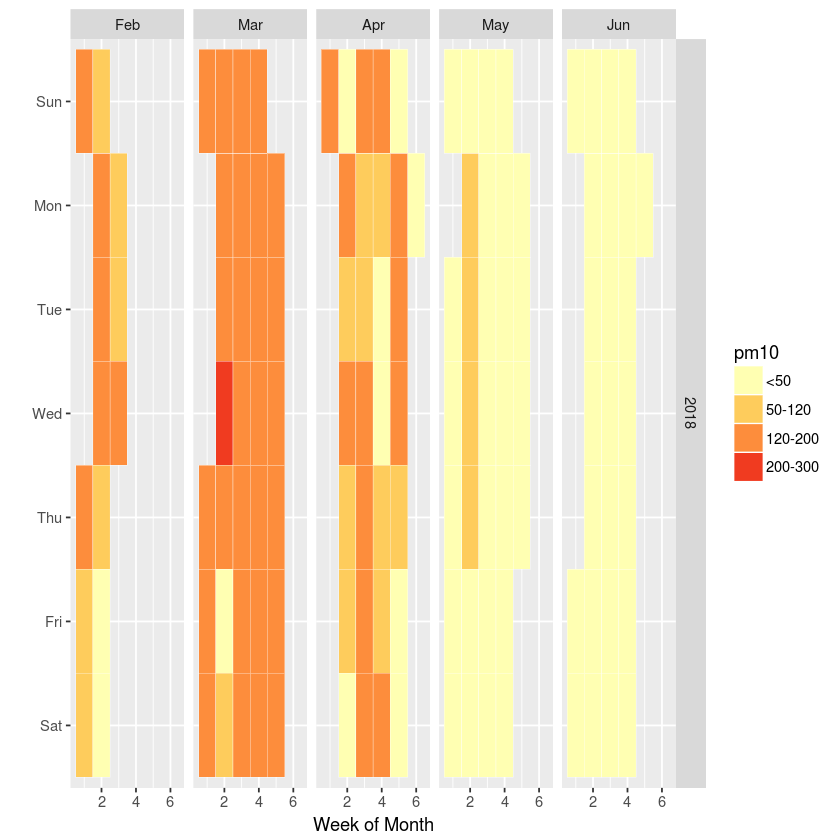

In [146]:
ggplot(airqdaily, aes(monthweek,dowf)) + geom_tile(aes(fill = pm10),colour = "white") + scale_fill_manual(values=c("#ffffb2","#fecc5c","#fd8d3c","#f03b20","grey"),labels = c("<50","50-120","120-200","200-300",">300"))+ facet_grid(y~monthf) + xlab("Week of Month") + ylab("")